In [ ]:
import pandas as pd
import dynet as dy
import numpy as np
import matplotlib.pyplot as plt
#import time
import os

from pathlib import Path

datafile = '\\data\\M3C.xls'
path = str(Path().absolute().parents[1]) #get dir 2 levels up 

In [44]:
df = pd.read_excel(path+datafile,sheet_name='M3Month')
df = df.set_index('Series')

ts1 = df.iloc[:,5:]
#align in time so nans are at the beginning - basically align right
ts2 = ts1.apply(lambda x: x.shift(len(list(ts1))-x.last_valid_index()),axis=1)
ts2.columns = range(ts2.shape[1])

In [63]:
#first valid index for each serie and length of each
first_valid = ts2.apply(lambda x: x.first_valid_index(),axis=1)
len_valid = ts2.shape[1]-first_valid

In [39]:
#one-hot categories, could use get dummies but it is better to save mapping
from sklearn.preprocessing import LabelBinarizer
cat_encoder = LabelBinarizer()
cats = pd.DataFrame(cat_encoder.fit_transform(df.Category),index = ts2.index,columns = cat_encoder.classes_)

In [139]:
class Forecaster(object):
    # The init method adds parameters to the parameter collection.
    def __init__(self, pc,input_len):
        self.W = []
        self.W.append(pc.add_parameters((10, input_len), init='normal', mean=0.5,std = 0.1))
        self.bias = pc.add_parameters((10), init='normal',mean=0,std = 0.1)
        self.W.append(pc.add_parameters((1, 10), init='normal', mean=0.5,std = 0.1))
    # the __call__ method applies the network to an input
    def __call__(self, x):
        y = self.W[0]*x
        y = self.W[1]*y
        #y = dy.rectify(y)
        return y


In [140]:
input_len = 5


#model one - per serie parameters
m1 = dy.ParameterCollection()
#model two - general params
m2 = dy.ParameterCollection()

class Params():
    def __init__(self,m1):
        self.alphas = m1.add_parameters((1), init=0.5)#alpha smoothing
        self.gammas = m1.add_parameters((1), init=0.5)#seasonal smoothing
        self.seasonals = m1.add_parameters((12),init='normal', mean=1., std=0.1)#seasonal component

#add per serie coefficients to the model
per_serie_params = []
SERIES = len(ts2)
for i in range(SERIES):
    per_serie_params.append(Params(m1))
fcstr = Forecaster(m2,input_len)

In [141]:
#get smoothing factors in the right scale
def get_smoothing_factors(per_serie):
    levelSm = dy.logistic(per_serie.alphas) #ensure positive
    seasonSm = dy.logistic(per_serie.gammas) #ensure positive
    seasonInit =  dy.rectify(per_serie.seasonals)+0.001 #make sure no zeros are there
    return levelSm, seasonSm, seasonInit

#perform exponential smoothing and return seasonal and level time-series
def smoothen(y,levelSm,seasonSm,seasonInit):
    newSeason = [seasonInit[i] for i in range(12)]
    newLevels = []
    
    #fill first fields
    newSeason.append(newSeason[0])
    newLevels.append(dy.cdiv(y[0],newSeason[0]))
    
    #Exponential smoothing - holt-winters like
    for i in range(1,y.dim()[0][0]):
        newLevels.append(levelSm*dy.cdiv(y[i],newSeason[i])+(1-levelSm)*newLevels[i-1])
        newSeason.append(seasonSm*dy.cdiv(y[i],newLevels[i])+(1-seasonSm)*newSeason[i])
    s = dy.concatenate(newSeason)
    l = dy.concatenate(newLevels)
    return s, l
def penalize_level(l):
    l_log_diff = dy.log(dy.cdiv(l[1:],l[0:l.dim()[0][0]-1]))
    l_penalty = l_log_diff[1:]-l_log_diff[0:l_log_diff.dim()[0][0]-1]
    return dy.mean_elems(dy.square(l_penalty))
    
#calculate loss for one serie
def calc_loss(x,fcstr,per_serie):
    length = len(x)
    y = dy.vecInput(len(x))
    y.set(x.values)
    levelSm, seasonSm, seasonInit = get_smoothing_factors(per_serie)
    s, l = smoothen(y,levelSm,seasonSm,seasonInit)
    
    level_loss = penalize_level(l)
    #penalize sudden level changes (should be scale independent - it is dependent)\
    #2nd order derivative is penalized
    
    
    preds = []
    outputs=[]
    
    #perform predictions with a nn 
    # horizon = 1
    for step in range(input_len,length-1):
        #lookback
        inputs = y[step-input_len:step]
        curr_season = s[step-input_len:step]
        inputs = dy.cdiv(inputs,l[step])
        inputs = dy.cdiv(inputs,curr_season)
        inputs = dy.log(inputs)
        #seasonal component of 1 step ahead
        reseasonalize = s[step+1]
        
        #perform prediction
        preds.append(dy.exp(fcstr(inputs))*l[step]*reseasonalize)          
        outputs.append(y[step+1])
        
    predictions = dy.concatenate(preds)
    outputs = dy.concatenate(outputs)
    loss =dy.mean_elems(dy.abs(outputs-predictions))
    return loss, level_loss, predictions

series_trainer = dy.SimpleSGDTrainer(m1,learning_rate = 0.03)
trainer = dy.SimpleSGDTrainer(m2,learning_rate = 0.025)
for epoch in range(100):    
    dy.renew_cg()
    losses = []
    err = []
    preds = []
    for serie in range(10):
        loss,level_loss, pred = calc_loss(ts2.iloc[serie,first_valid[serie]:],fcstr,per_serie_params[serie])
        #todo - parametrize 
        losses.append(loss+level_loss)
        err.append(loss)
        preds.append(pred.value(recalculate=True))
    batch_loss = dy.average(losses)
    batch_loss.backward()
    trainer.update()
    series_trainer.update()
    print(batch_loss.value(recalculate=True),'W fstr',fcstr.W[0].npvalue()[0,:3])  

89248.640625 W fstr [0.48121849 0.38122085 0.35775673]
36336.5234375 W fstr [0.47379151 0.37315121 0.34953597]
17450.48046875 W fstr [0.46694532 0.36550361 0.34161577]
9581.0498046875 W fstr [0.46065113 0.35831112 0.33408713]
5862.49658203125 W fstr [0.45479366 0.35163617 0.32705817]
3903.251953125 W fstr [0.44930959 0.34555355 0.32060316]
2783.4970703125 W fstr [0.4441365  0.34017494 0.31493649]
2083.3818359375 W fstr [0.4391669 0.3354038 0.3101638]
1634.410888671875 W fstr [0.4346883  0.33086261 0.30647784]
1404.676025390625 W fstr [0.43084839 0.3268536  0.30322149]
1596.5699462890625 W fstr [0.42690077 0.32539445 0.30689269]
1381.1673583984375 W fstr [0.42944798 0.32815638 0.30997574]
1557.540771484375 W fstr [0.42616257 0.3262518  0.31290662]
1361.903564453125 W fstr [0.42864254 0.32906127 0.31571817]
1532.4556884765625 W fstr [0.42582673 0.32671461 0.31574854]
1345.843505859375 W fstr [0.42830324 0.32944843 0.31849536]
1511.554931640625 W fstr [0.42539081 0.32660228 0.31834522]
13

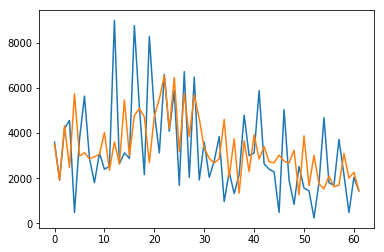

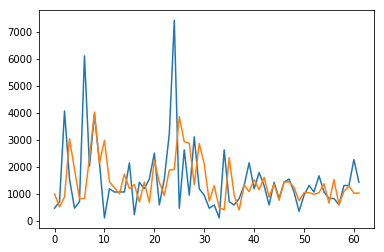

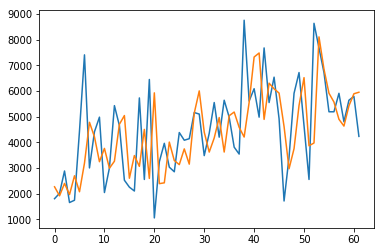

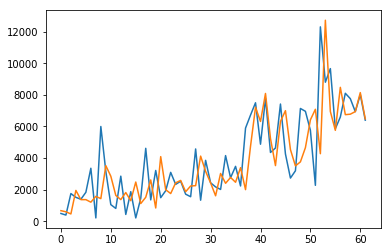

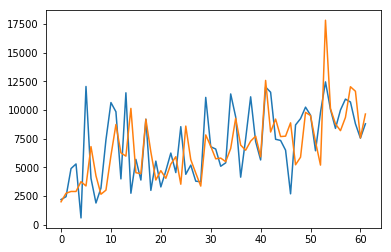

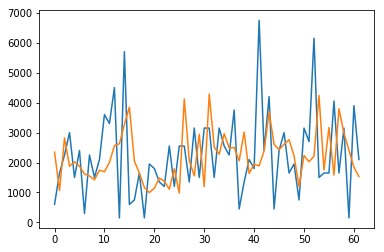

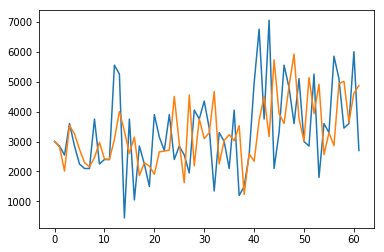

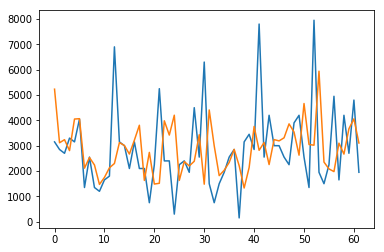

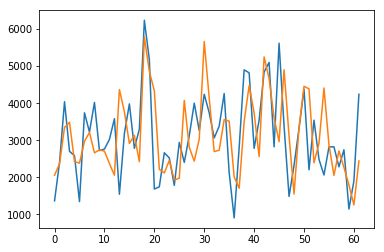

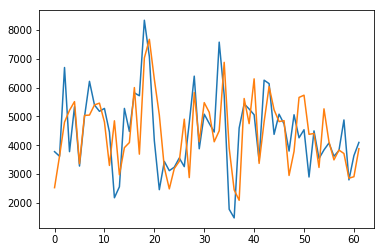

In [142]:
for serie in range(10):
    plt.plot(ts2.iloc[serie,first_valid[serie]+input_len+1:].values)
    plt.plot(preds[serie])
    plt.show()

In [ ]:

#no seasonal model!!!!-----------------------
#block seasonality
# seasonInit = dy.ones((12,1))
# seasonSm = dy.zeros(1,1)






#Like Smyl's




#penalize sudden level changes (should be scale independent - it is dependent)\
#should penalize 2nd derivative
l_log_diff = dy.log(dy.cdiv(l[1:],l[0:l.dim()[0][0]-1]))
l_penalty = l_log_diff[1:]-l_log_diff[0:l_log_diff.dim()[0][0]-1]
level_loss = dy.mean_elems(dy.square(l_penalty))*10
print(level_loss.value())

preds = []
outputs=[]

#wez y i usun sezonowosc i level
for i in range(n,len(df)-h):
    inputs = y[i-n:i]#n okresy
    curr_season = s[i-n:i]
    inputs = dy.cdiv(inputs,l[i])
    inputs = dy.cdiv(inputs,curr_season)
    inputs = dy.log(inputs)
    reseasonalize = s[i+1]#poprzedni okres +1 krok
    preds.append(dy.exp(fcstr(inputs))*l[i]*reseasonalize)          
    outputs.append(y[i+1])#+1 krok
predictions = dy.concatenate(preds)
outputs = dy.concatenate(outputs)

#log_err = dy.mean_elems(dy.abs(dy.log(outputs)-dy.log(predictions)))
err =dy.mean_elems(dy.abs(outputs-predictions))
loss = err + level_loss

trainer = dy.SimpleSGDTrainer(m,learning_rate = 0.25)

loss_value = loss.value()
print(seasonInit.npvalue())
for i in range(2000):
    loss.backward()
    trainer.update()
    loss_value = loss.value(recalculate=True)
    trainer.learning_rate *=0.992 #0.99 lr decay
    
    if i%50==0 or i<10:
        
        print("the mae after step is:",err.value(recalculate=True))
        print("the loss after step is:",loss_value)
        print('l_loss1: ',level_loss.value(recalculate=True))
        plt.plot(predictions.value(recalculate=True),label = 'Pred')
        plt.plot(l.value(recalculate=True),label = 'lvl')
        plt.plot(outputs.value(),label ='gt')
        plt.show()

print('levelSm ',levelSm.npvalue())
print('seaosonSm ',seasonSm.npvalue())
print('init season ',seasonInit.npvalue())

plt.plot(l.value(recalculate=True))
plt.title('Level')
plt.show()
plt.plot(s.value(recalculate=True))
plt.title('Seasonal')
plt.show()

In [ ]:
from pandas.plotting import autocorrelation_plot
#autocorrelation_plot(pd.Series(l.value(recalculate=True)[:,0]))
# plt.show()
autocorrelation_plot(df)
autocorrelation_plot(l.value())